Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\SAYALI\Downloads\New folder\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\SAYALI\AppData\Local\Temp\ipykernel_24540\2804793823.py", line 92, in optimize_energy
    energy_vars = cp.Variable(len(device_names))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SAYALI\Downloads\New folder\Lib\site-packages\cvxpy\expressions\variable.py", line 51, in __init__
    super(Variable, self).__init__(shape, **kwargs)
  File "C:\Users\SAYALI\Downloads\New folder\Lib\site-packages\cvxpy\expressions\leaf.py", line 113, in __init__
    raise ValueError("Invalid dimensions %s." % (shape,))
ValueError: Invalid dimensions (0,).


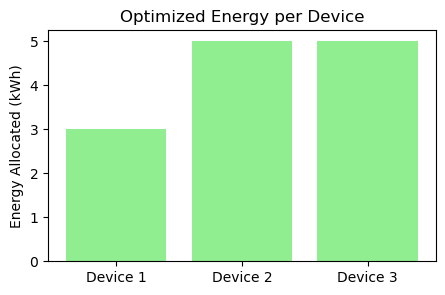

In [1]:
from tkinter import *
from tkinter import messagebox
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SmartBuildingEnergyOptimizer:
    def __init__(self, root):
        self.root = root
        self.root.title("Smart Building Energy Optimizer")
        self.root.configure(bg="#E6E6FA")

        # Title
        title = Label(root, text="Energy Optimization in Smart Buildings", font=("Helvetica", 16, "bold"), bg="#E6E6FA")
        title.pack(pady=10)

        # Input Frame
        input_frame = Frame(root, bg="#E6E6FA")
        input_frame.pack()

        Label(input_frame, text="Number of Devices:", bg="#E6E6FA").grid(row=0, column=0)
        self.device_count_entry = Entry(input_frame)
        self.device_count_entry.grid(row=0, column=1)

        Label(input_frame, text="Cost per Unit (₹/kWh):", bg="#E6E6FA").grid(row=1, column=0)
        self.cost_entry = Entry(input_frame)
        self.cost_entry.grid(row=1, column=1)

        Label(input_frame, text="Total Energy Limit (kWh):", bg="#E6E6FA").grid(row=2, column=0)
        self.total_energy_entry = Entry(input_frame)
        self.total_energy_entry.grid(row=2, column=1)

        self.set_devices_btn = Button(input_frame, text="Set Devices", command=self.create_device_entries)
        self.set_devices_btn.grid(row=0, column=2, padx=10)

        self.device_entries_frame = Frame(root, bg="#E6E6FA")
        self.device_entries_frame.pack(pady=10)

        self.device_entries = []

        self.optimize_btn = Button(root, text="Optimize Energy Usage", command=self.optimize_energy, bg="green", fg="white")
        self.optimize_btn.pack(pady=10)

        self.output_text = Text(root, height=10, width=70)
        self.output_text.pack(pady=10)

        # Plot
        self.figure, self.ax = plt.subplots(figsize=(5, 3))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas.get_tk_widget().pack()

    def create_device_entries(self):
        for widget in self.device_entries_frame.winfo_children():
            widget.destroy()
        self.device_entries = []

        try:
            count = int(self.device_count_entry.get())
        except ValueError:
            messagebox.showerror("Invalid Input", "Please enter a valid number of devices.")
            return

        Label(self.device_entries_frame, text="Enter Device Names and Max Energy (kWh):", bg="#E6E6FA").pack()

        for i in range(count):
            frame = Frame(self.device_entries_frame, bg="#E6E6FA")
            frame.pack()
            device_name_entry = Entry(frame)
            device_name_entry.insert(0, f"Device {i+1}")
            device_name_entry.pack(side=LEFT, padx=5)
            max_energy_entry = Entry(frame)
            max_energy_entry.pack(side=LEFT, padx=5)
            self.device_entries.append((device_name_entry, max_energy_entry))

    def optimize_energy(self):
        try:
            cost_per_unit = float(self.cost_entry.get())
            total_energy_limit = float(self.total_energy_entry.get())
            device_names = [entry[0].get() for entry in self.device_entries]
            device_max_energy = [float(entry[1].get()) for entry in self.device_entries]
        except ValueError:
            messagebox.showerror("Error", "Please fill in all fields with valid numbers.")
            return

        total_max_energy = sum(device_max_energy)

        if total_max_energy < total_energy_limit:
            messagebox.showwarning("Warning", "Total max energy of all devices is less than the energy limit. Some capacity may be unused.")
        elif total_max_energy > total_energy_limit:
            messagebox.showinfo("Note", "Energy required by devices exceeds total limit. Optimizing accordingly...")

        energy_vars = cp.Variable(len(device_names))
        constraints = [energy_vars >= 0, energy_vars <= device_max_energy, cp.sum(energy_vars) <= total_energy_limit]

        problem = cp.Problem(cp.Maximize(cp.sum(energy_vars)), constraints)
        problem.solve()

        self.output_text.delete("1.0", END)
        self.output_text.insert(END, "✅ Optimized Energy Allocation:\n\n")
        total_used = 0
        for i, name in enumerate(device_names):
            val = round(energy_vars.value[i], 2) if energy_vars.value[i] else 0.0
            total_used += val
            self.output_text.insert(END, f"{name}: {val:.2f} kWh (Max: {device_max_energy[i]:.2f})\n")

        unused = total_energy_limit - total_used
        cost = total_used * cost_per_unit
        self.output_text.insert(END, f"\nTotal Energy Used: {total_used:.2f} kWh")
        self.output_text.insert(END, f"\nUnused Capacity: {unused:.2f} kWh")
        self.output_text.insert(END, f"\nTotal Cost: ₹{cost:.2f}")

        # Plot graph
        self.ax.clear()
        self.ax.bar(device_names, [max(val, 0) for val in energy_vars.value], color='lightgreen')
        self.ax.set_title("Optimized Energy per Device")
        self.ax.set_ylabel("Energy Allocated (kWh)")
        self.canvas.draw()

# Run the application
root = Tk()
app = SmartBuildingEnergyOptimizer(root)
root.mainloop()
